In [ ]:
from pathlib import Path

import pandas as pd

#macbook path:
'''
# #DEFAULT_CSV_PATH = Path(
    "/Users/pkiszk/Library/CloudStorage/OneDrive-Osobisty/009_PK/08 Learning/"
    "Curtailment_Excel/PSE_gen-jw_2025-01.csv"
    )
'''

#PC Path:
DEFAULT_CSV_PATH = Path(
    "/home/magda/projects/pyPSA-PL/PSE_gen-jw_2025-01.csv"
)


def load_pse_gen_jw_csv(csv_path: Path | str = DEFAULT_CSV_PATH) -> pd.DataFrame:
    """Load PSE_gen-jw CSV into a pandas DataFrame."""
    path = Path(csv_path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"CSV file not found: {path}")
    return pd.read_csv(path)


def min_positive_per_resource(df: pd.DataFrame) -> pd.DataFrame:
    """Return one row per resource_code with the minimum positive wartosc."""
    required = {"resource_code", "wartosc"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    work = df.copy()
    work["wartosc"] = pd.to_numeric(work["wartosc"], errors="coerce")
    positive = work[work["wartosc"] > 0].copy()
    if positive.empty:
        return positive

    idx = positive.groupby("resource_code")["wartosc"].idxmin()
    result = positive.loc[idx].sort_values(["resource_code", "wartosc"])
    return result


def records_for_resource(df: pd.DataFrame, resource_code: str) -> pd.DataFrame:
    """Return all records for a given resource_code."""
    if "resource_code" not in df.columns:
        raise ValueError("Missing required column: resource_code")
    return df[df["resource_code"] == resource_code].copy()


if __name__ == "__main__":
    df = load_pse_gen_jw_csv()
    print(f"Loaded {len(df)} rows x {len(df.columns)} columns from: {DEFAULT_CSV_PATH}")
    print("\nHeaders:")
    print(df.columns.tolist())
    print("\nFirst rows:")
    print(df.head())

    minima = min_positive_per_resource(df)
    print("\nMinimum positive wartosc per resource_code:")
    if minima.empty:
        print("No positive values found.")
    else:
        cols = [c for c in ["resource_code", "wartosc", "dtime", "period", "power_plant"] if c in minima.columns]
        print(minima[cols].to_string(index=False))

    # target_resource = "BEL 2-02"
    # target_df = records_for_resource(df, target_resource)
    # print(f"\nAll records for {target_resource}: {len(target_df)} rows")
    # if target_df.empty:
    #     print("No matching records found.")
    # else:
    #     print(target_df.to_string(index=False))


<>:15: SyntaxWarning: invalid escape sequence '\h'
<>:15: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_2756/3183160323.py:15: SyntaxWarning: invalid escape sequence '\h'
  "\home\magda\projects\pyPSA-PL\PSE_gen-jw_2025-01.csv"
/tmp/ipykernel_2756/3183160323.py:15: SyntaxWarning: invalid escape sequence '\h'
  "\home\magda\projects\pyPSA-PL\PSE_gen-jw_2025-01.csv"


FileNotFoundError: CSV file not found: \home\magda\projects\pyPSA-PL\PSE_gen-jw_2025-01.csv

In [ ]:
import pandas as pd

def resource_wartosc_stats_jupyter(df: pd.DataFrame, resource_code: str = "BEL 2-02") -> tuple[float, float]:
    """Return (minimum non-zero wartosc, 5th percentile of non-zero wartosc)."""
    required = {"resource_code", "wartosc"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    subset = df[df["resource_code"] == resource_code].copy()
    if subset.empty:
        raise ValueError(f"No rows found for resource_code={resource_code!r}")

    wartosc = pd.to_numeric(subset["wartosc"], errors="coerce").dropna()
    if wartosc.empty:
        raise ValueError(f"No numeric wartosc values for resource_code={resource_code!r}")

    positive = wartosc[wartosc > 0]
    if positive.empty:
        raise ValueError(f"No positive wartosc values for resource_code={resource_code!r}")

    non_zero = wartosc[wartosc != 0]
    if non_zero.empty:
        raise ValueError(f"No non-zero wartosc values for resource_code={resource_code!r}")

    min_non_zero = float(positive.min())
    p5 = float(non_zero.quantile(0.05))
    return min_non_zero, p5

# Example:
min_non_zero, p5 = resource_wartosc_stats_jupyter(df, "BEL 2-02")
print(min_non_zero, p5)


7.0278 218.54853


In [ ]:
import pandas as pd

def zero_streaks_hours_jupyter(df: pd.DataFrame, resource_code: str = "BEL 2-02") -> pd.DataFrame:
    """Return consecutive zero-value wartosc streaks with lengths in hours."""
    required = {"resource_code", "wartosc"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    subset = df[df["resource_code"] == resource_code].copy()
    if subset.empty:
        raise ValueError(f"No rows found for resource_code={resource_code!r}")

    ts_col = "dtime_utc" if "dtime_utc" in subset.columns else "dtime"
    if ts_col not in subset.columns:
        raise ValueError("Missing timestamp column: expected dtime_utc or dtime")

    subset["timestamp"] = pd.to_datetime(subset[ts_col], errors="coerce")
    subset["wartosc"] = pd.to_numeric(subset["wartosc"], errors="coerce")
    subset = subset.dropna(subset=["timestamp", "wartosc"]).sort_values("timestamp")
    if subset.empty:
        raise ValueError(f"No valid timestamp/wartosc rows for resource_code={resource_code!r}")

    diffs = subset["timestamp"].diff().dt.total_seconds().div(3600)
    diffs = diffs[diffs > 0]
    step_hours = float(diffs.mode().iloc[0]) if not diffs.empty else 0.25
    tolerance = max(1e-9, step_hours * 0.01)

    is_zero = subset["wartosc"] == 0
    gap_break = diffs.reindex(subset.index).fillna(step_hours).sub(step_hours).abs() > tolerance
    starts = is_zero & ((~is_zero.shift(fill_value=False)) | gap_break)
    streak_id = starts.cumsum()

    zero_rows = subset[is_zero].copy()
    if zero_rows.empty:
        return pd.DataFrame(columns=["streak_id", "start_ts", "end_ts", "intervals", "hours"])

    zero_rows["streak_id"] = streak_id[is_zero]
    streaks = (
        zero_rows.groupby("streak_id")
        .agg(
            start_ts=("timestamp", "min"),
            end_ts=("timestamp", "max"),
            intervals=("timestamp", "size"),
        )
        .reset_index()
    )
    streaks["hours"] = streaks["intervals"] * step_hours
    return streaks

# Example:
streaks = zero_streaks_hours_jupyter(df, "BEL 2-02")
display(streaks)
print("Longest zero streak [h]:", streaks["hours"].max() if not streaks.empty else 0.0)


,streak_id,start_ts,end_ts,intervals,hours
0,1,2025-01-01 00:00:00,2025-01-02 04:00:00,113,28.25
1,2,2025-01-06 00:15:00,2025-01-07 07:15:00,125,31.25
2,3,2025-01-09 23:00:00,2025-01-14 17:30:00,459,114.75
3,4,2025-01-24 22:00:00,2025-01-25 14:00:00,65,16.25
4,5,2025-01-26 13:00:00,2025-01-27 12:30:00,95,23.75


Longest zero streak [h]: 114.75


In [ ]:
# Final BEL 2-02 analysis
target_resource = "BEL 2-02"
min_non_zero, p5_non_zero = resource_wartosc_stats_jupyter(df, target_resource)
print(f"{target_resource} minimum non-zero wartosc: {min_non_zero:.4f}")
print(f"{target_resource} wartosc 5th percentile (excluding zeros): {p5_non_zero:.4f}")


BEL 2-02 minimum non-zero wartosc: 7.0278
BEL 2-02 wartosc 5th percentile (excluding zeros): 218.5485


In [ ]:
# Zero-value streak lengths (hours) for BEL 2-02
streaks = zero_streaks_hours_jupyter(df, target_resource)
display(streaks)
print("Zero streak lengths [h]:", streaks["hours"].tolist())
print("Longest zero streak [h]:", float(streaks["hours"].max()) if not streaks.empty else 0.0)


,streak_id,start_ts,end_ts,intervals,hours
0,1,2025-01-01 00:00:00,2025-01-02 04:00:00,113,28.25
1,2,2025-01-06 00:15:00,2025-01-07 07:15:00,125,31.25
2,3,2025-01-09 23:00:00,2025-01-14 17:30:00,459,114.75
3,4,2025-01-24 22:00:00,2025-01-25 14:00:00,65,16.25
4,5,2025-01-26 13:00:00,2025-01-27 12:30:00,95,23.75


Zero streak lengths [h]: [28.25, 31.25, 114.75, 16.25, 23.75]
Longest zero streak [h]: 114.75


In [ ]:
import pandas as pd

def bel_codes_stats_jupyter(df: pd.DataFrame) -> pd.DataFrame:
    """Stats for all resource_code values starting with BEL."""
    if "resource_code" not in df.columns:
        raise ValueError("Missing required column: resource_code")

    bel_codes = sorted(code for code in df["resource_code"].dropna().unique() if str(code).startswith("BEL"))
    rows = []
    for code in bel_codes:
        min_non_zero, p5_non_zero = resource_wartosc_stats_jupyter(df, code)
        streaks = zero_streaks_hours_jupyter(df, code)
        streak_hours = streaks["hours"].round(2).tolist() if not streaks.empty else []
        rows.append({
            "resource_code": code,
            "min_non_zero_wartosc": float(min_non_zero),
            "p5_non_zero_wartosc": float(p5_non_zero),
            "zero_streak_count": int(len(streaks)),
            "longest_zero_streak_h": float(streaks["hours"].max()) if not streaks.empty else 0.0,
            "zero_streak_hours": streak_hours,
        })

    return pd.DataFrame(rows).sort_values("resource_code").reset_index(drop=True)


In [ ]:
# Final BEL list + stats table
bel_stats = bel_codes_stats_jupyter(df)
print("BEL resource_code list:")
print(bel_stats["resource_code"].tolist())
display(bel_stats)
print(f"Total p5_non_zero_wartosc across BEL codes: {bel_stats['p5_non_zero_wartosc'].sum():.4f}")


BEL resource_code list:
['BEL 2-02', 'BEL 2-03', 'BEL 2-04', 'BEL 2-05', 'BEL 4-06', 'BEL 4-07', 'BEL 4-08', 'BEL 4-09', 'BEL 4-10', 'BEL 4-11', 'BEL 4-12', 'BEL 4-14']


,resource_code,min_non_zero_wartosc,p5_non_zero_wartosc,zero_streak_count,longest_zero_streak_h,zero_streak_hours
0,BEL 2-02,7.0278,218.548530,5,114.75,"[28.25, 31.25, 114.75, 16.25, 23.75]"
1,BEL 2-03,20.7000,184.514670,2,6.75,"[6.5, 6.75]"
2,BEL 2-04,1.9864,183.795805,2,76.25,"[30.75, 76.25]"
3,BEL 2-05,4.0200,180.852000,6,28.25,"[28.25, 8.5, 10.5, 7.5, 9.75, 28.25]"
4,BEL 4-06,16.1700,182.924500,5,29.50,"[29.5, 8.5, 13.25, 28.25, 7.0]"
5,BEL 4-07,4.2503,183.532850,4,81.25,"[35.5, 81.25, 6.75, 52.75]"
6,BEL 4-08,4.5219,184.560850,5,54.25,"[6.5, 9.75, 38.25, 54.25, 1.25]"
7,BEL 4-09,16.3500,184.420000,3,29.00,"[29.0, 7.25, 6.5]"
8,BEL 4-10,3.3123,185.374810,6,76.00,"[30.0, 45.5, 7.0, 76.0, 9.5, 25.25]"
9,BEL 4-11,4.6207,183.724970,5,64.50,"[53.0, 31.75, 20.75, 6.5, 64.5]"


Total p5_non_zero_wartosc across BEL codes: 2488.0901


In [ ]:
import numpy as np
import pandas as pd

EXCLUDED_PERCENTILE_CODE_PREFIXES = ("ZRN", "PZR", "JW7", "WLC", "ZGR", "SNA", "ZWA")

def is_excluded_from_percentiles_jupyter(resource_code: str) -> bool:
    code = str(resource_code)
    return any(code.startswith(prefix) for prefix in EXCLUDED_PERCENTILE_CODE_PREFIXES)

def get_percentile_base_codes_jupyter(df: pd.DataFrame) -> list[str]:
    if "resource_code" not in df.columns:
        raise ValueError("Missing required column: resource_code")
    all_codes = sorted(code for code in df["resource_code"].dropna().unique())
    return [code for code in all_codes if not is_excluded_from_percentiles_jupyter(code)]

def all_codes_stats_jupyter(df: pd.DataFrame) -> pd.DataFrame:
    """Stats for all unique resource_code values."""
    if "resource_code" not in df.columns:
        raise ValueError("Missing required column: resource_code")

    codes = sorted(code for code in df["resource_code"].dropna().unique())
    percentile_base_codes = set(get_percentile_base_codes_jupyter(df))
    rows = []
    for code in codes:
        subset = df[df["resource_code"] == code].copy()
        wartosc = pd.to_numeric(subset["wartosc"], errors="coerce").dropna()
        positive = wartosc[wartosc > 0]
        non_zero = wartosc[wartosc != 0]
        percentile_base_included = code in percentile_base_codes

        streaks = zero_streaks_hours_jupyter(df, code)
        streak_hours = streaks["hours"].round(2).tolist() if not streaks.empty else []

        rows.append({
            "resource_code": code,
            "percentile_base_included": percentile_base_included,
            "min_non_zero_wartosc": float(positive.min()) if not positive.empty else np.nan,
            "p1_non_zero_wartosc": float(non_zero.quantile(0.01)) if (percentile_base_included and not non_zero.empty) else np.nan,
            "p2_non_zero_wartosc": float(non_zero.quantile(0.02)) if (percentile_base_included and not non_zero.empty) else np.nan,
            "p3_non_zero_wartosc": float(non_zero.quantile(0.03)) if (percentile_base_included and not non_zero.empty) else np.nan,
            "p5_non_zero_wartosc": float(non_zero.quantile(0.05)) if (percentile_base_included and not non_zero.empty) else np.nan,
            "zero_streak_count": int(len(streaks)),
            "longest_zero_streak_h": float(streaks["hours"].max()) if not streaks.empty else 0.0,
            "zero_streak_hours": streak_hours,
        })

    return pd.DataFrame(rows).sort_values("resource_code").reset_index(drop=True)

def p5_subtotals_by_family_jupyter(stats_df: pd.DataFrame) -> pd.DataFrame:
    """Subtotal p1/p2/p3/p5 by code family prefix (e.g., BEL, KOZ)."""
    required = {"resource_code", "p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"}
    missing = required - set(stats_df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    work = stats_df.copy()
    if "percentile_base_included" not in work.columns:
        work["percentile_base_included"] = ~work["resource_code"].apply(is_excluded_from_percentiles_jupyter)

    work["code_family"] = (
        work["resource_code"].astype(str).str.extract(r"^([A-Za-z]+)", expand=False).fillna("UNKNOWN")
    )

    subtotals = (
        work.groupby("code_family", as_index=False)
        .agg(
            resource_code_count=("resource_code", "size"),
            percentile_base_code_count=("percentile_base_included", "sum"),
            p1_non_zero_wartosc_subtotal=("p1_non_zero_wartosc", "sum"),
            p2_non_zero_wartosc_subtotal=("p2_non_zero_wartosc", "sum"),
            p3_non_zero_wartosc_subtotal=("p3_non_zero_wartosc", "sum"),
            p5_non_zero_wartosc_subtotal=("p5_non_zero_wartosc", "sum"),
        )
        .sort_values("code_family")
        .reset_index(drop=True)
    )
    return subtotals


In [ ]:
# Final all-codes totals + family subtotals
all_stats = all_codes_stats_jupyter(df)
display(all_stats)
percentile_base_count = int(all_stats["percentile_base_included"].sum())
print(
    f"Percentile base codes: {percentile_base_count}/{len(all_stats)} "
    f"(excluded prefixes: {list(EXCLUDED_PERCENTILE_CODE_PREFIXES)})"
)
grand_total_p1 = float(all_stats["p1_non_zero_wartosc"].sum(skipna=True))
grand_total_p2 = float(all_stats["p2_non_zero_wartosc"].sum(skipna=True))
grand_total_p3 = float(all_stats["p3_non_zero_wartosc"].sum(skipna=True))
grand_total = float(all_stats["p5_non_zero_wartosc"].sum(skipna=True))
print(f"Grand total p1_non_zero_wartosc across all codes: {grand_total_p1:.4f}")
print(f"Grand total p2_non_zero_wartosc across all codes: {grand_total_p2:.4f}")
print(f"Grand total p3_non_zero_wartosc across all codes: {grand_total_p3:.4f}")
print(f"Grand total p5_non_zero_wartosc across all codes: {grand_total:.4f}")

family_subtotals = p5_subtotals_by_family_jupyter(all_stats)
display(family_subtotals)


,resource_code,percentile_base_included,min_non_zero_wartosc,p1_non_zero_wartosc,p2_non_zero_wartosc,p3_non_zero_wartosc,p5_non_zero_wartosc,zero_streak_count,longest_zero_streak_h,zero_streak_hours
0,BEL 2-02,True,7.0278,83.522700,182.665556,218.268958,218.548530,5,114.75,"[28.25, 31.25, 114.75, 16.25, 23.75]"
1,BEL 2-03,True,20.7000,182.015814,182.606568,183.048646,184.514670,2,6.75,"[6.5, 6.75]"
2,BEL 2-04,True,1.9864,181.802744,182.577896,183.101986,183.795805,2,76.25,"[30.75, 76.25]"
3,BEL 2-05,True,4.0200,154.035600,180.210000,180.420000,180.852000,6,28.25,"[28.25, 8.5, 10.5, 7.5, 9.75, 28.25]"
4,BEL 4-06,True,16.1700,157.514000,181.400000,181.988700,182.924500,5,29.50,"[29.5, 8.5, 13.25, 28.25, 7.0]"
...,...,...,...,...,...,...,...,...,...,...
102,ZRN_4-01,False,32.8000,NaN,NaN,NaN,NaN,1823,50.75,"[0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25..."
103,ZRN_4-02,False,94.1000,NaN,NaN,NaN,NaN,1185,127.25,"[7.0, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, ..."
104,ZRN_4-03,False,131.0000,NaN,NaN,NaN,NaN,1107,85.25,"[0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25..."
105,ZRN_4-04,False,142.0000,NaN,NaN,NaN,NaN,1645,79.00,"[0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25..."


Percentile base codes: 93/107 (excluded prefixes: ['ZRN', 'PZR', 'JW7', 'WLC', 'ZGR', 'SNA', 'ZWA'])
Grand total p1_non_zero_wartosc across all codes: 9446.2526
Grand total p2_non_zero_wartosc across all codes: 10879.4531
Grand total p3_non_zero_wartosc across all codes: 11784.4536
Grand total p5_non_zero_wartosc across all codes: 12579.7775


,code_family,resource_code_count,percentile_base_code_count,p1_non_zero_wartosc_subtotal,p2_non_zero_wartosc_subtotal,p3_non_zero_wartosc_subtotal,p5_non_zero_wartosc_subtotal
0,BEL,12,12,1970.999945,2385.416102,2439.406504,2488.090075
1,CHZ,2,2,116.380000,117.690000,118.010000,118.640000
2,CZN,1,1,53.155000,54.500000,54.600000,54.800000
3,DOD,4,4,181.657000,245.854000,280.215000,311.320000
4,EGF,2,2,224.750000,305.924000,422.168000,531.905000
5,JW,7,7,455.843000,550.326000,669.235000,793.755000
6,KAR,2,2,44.476998,75.375416,86.431090,88.430770
7,KAT,1,1,62.917500,63.940000,65.400000,66.290000
8,KLE,4,4,206.672517,212.830510,219.420233,234.748980
9,KOZ,11,11,1879.859335,1951.398612,1998.131470,2034.460545


In [ ]:
import sys
from pathlib import Path
from tkinter import N

# Switch this when changing machines.
PSE_DIR = Path("/home/magda/projects/pyPSA-PL")  # linux
# PSE_DIR = Path("/Users/pkiszk/Coding/pyPSA-PL/PyPSA_workspace")  # mac

sys.path.insert(0, str(PSE_DIR))
from csv_analyser import load_pse_gen_jw_csv, all_codes_stats

#jan
new_file = PSE_DIR / "PSE_gen-jw_2025-01.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("Jan data: ")
print(totals.to_string())

#feb

new_file = PSE_DIR / "PSE_gen-jw_20260212_191444.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("Feb data: ")
print(totals.to_string())


#MARCH 2025
new_file = PSE_DIR / "PSE_gen-jw_20260212_193540.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("March data")
print(totals.to_string())

#April  2025
new_file = PSE_DIR / "PSE_gen-jw_20260212_194112.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("April data:")
print(totals.to_string())


# may: PSE_gen-jw_20260212_194619.csv
new_file = PSE_DIR / "PSE_gen-jw_20260212_194619.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("May data:")
print(totals.to_string())


# june: PSE_gen-jw_20260212_195130.csv

new_file = PSE_DIR / "PSE_gen-jw_20260212_195130.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("June data:")
print(totals.to_string())

# july PSE_gen-jw_20260212_195823.csv
new_file = PSE_DIR / "PSE_gen-jw_20260212_195823.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("July data:")
print(totals.to_string())

# aug PSE_gen-jw_20260212_200747
new_file = PSE_DIR / "PSE_gen-jw_20260212_200747.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("Aug data:")
print(totals.to_string())

# sep PSE_gen-jw_20260212_201342.csv
new_file = PSE_DIR / "PSE_gen-jw_20260212_201342.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("Sep data:")
print(totals.to_string())

# PSE_gen-jw_20260212_202203.csv
new_file = PSE_DIR / "PSE_gen-jw_20260212_202203.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("Oct data:")
print(totals.to_string())

#nov
new_file = PSE_DIR / "PSE_gen-jw_20260212_202815.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("Nov  data:")
print(totals.to_string())

# dec PSE_gen-jw_20260212_204546.csv
new_file = PSE_DIR / "PSE_gen-jw_20260212_204546.csv"
df_new = load_pse_gen_jw_csv(new_file)
all_stats_new = all_codes_stats(df_new)

totals = all_stats_new[
    ["p1_non_zero_wartosc", "p2_non_zero_wartosc", "p3_non_zero_wartosc", "p5_non_zero_wartosc"]
].sum(skipna=True)

print("Nov  data:")
print(totals.to_string())


Feb data: 
p1_non_zero_wartosc     9446.252599
p2_non_zero_wartosc    10879.453120
p3_non_zero_wartosc    11784.453566
p5_non_zero_wartosc    12579.777455
Feb data: 
p1_non_zero_wartosc    10038.775684
p2_non_zero_wartosc    11232.343584
p3_non_zero_wartosc    11860.082314
p5_non_zero_wartosc    12890.787465
March data
p1_non_zero_wartosc     8624.865462
p2_non_zero_wartosc    10159.472274
p3_non_zero_wartosc    10789.125464
p5_non_zero_wartosc    11494.176700
April data:
p1_non_zero_wartosc     8690.763445
p2_non_zero_wartosc    10472.319792
p3_non_zero_wartosc    11182.500770
p5_non_zero_wartosc    12030.087695
May data:
p1_non_zero_wartosc     7116.885351
p2_non_zero_wartosc     9057.234674
p3_non_zero_wartosc    10149.586907
p5_non_zero_wartosc    11068.765680
June data:
p1_non_zero_wartosc    6788.433396
p2_non_zero_wartosc    8275.467002
p3_non_zero_wartosc    9114.246363
p5_non_zero_wartosc    9983.596405
July data:
p1_non_zero_wartosc     7559.176688
p2_non_zero_wartosc     918

,label,file_name,p1_non_zero_wartosc,p2_non_zero_wartosc,p3_non_zero_wartosc,p5_non_zero_wartosc
0,Feb 2025,PSE_gen-jw_20260212_191444.csv,10038.775684,11232.343584,11860.082314,12890.787465
1,Mar 2025,PSE_gen-jw_20260212_193540.csv,8624.865462,10159.472274,10789.125464,11494.176700
2,Apr 2025,PSE_gen-jw_20260212_194112.csv,8690.763445,10472.319792,11182.500770,12030.087695
3,May 2025,PSE_gen-jw_20260212_194619.csv,7116.885351,9057.234674,10149.586907,11068.765680
4,Jun 2025,PSE_gen-jw_20260212_195130.csv,6788.433396,8275.467002,9114.246363,9983.596405
5,Jul 2025,PSE_gen-jw_20260212_195823.csv,7559.176688,9183.447252,9983.593130,10908.545220
6,Aug 2025,PSE_gen-jw_20260212_200747.csv,7384.078298,8983.393976,9784.774109,10475.085545
7,Sep 2025,PSE_gen-jw_20260212_201342.csv,7823.658095,9328.582914,9975.597061,10854.300025
8,Oct 2025,PSE_gen-jw_20260212_202203.csv,8869.083744,10317.049202,11041.614145,11608.144305
9,Nov 2025,PSE_gen-jw_20260212_202815.csv,10072.890624,11499.402128,12128.125145,12776.725765


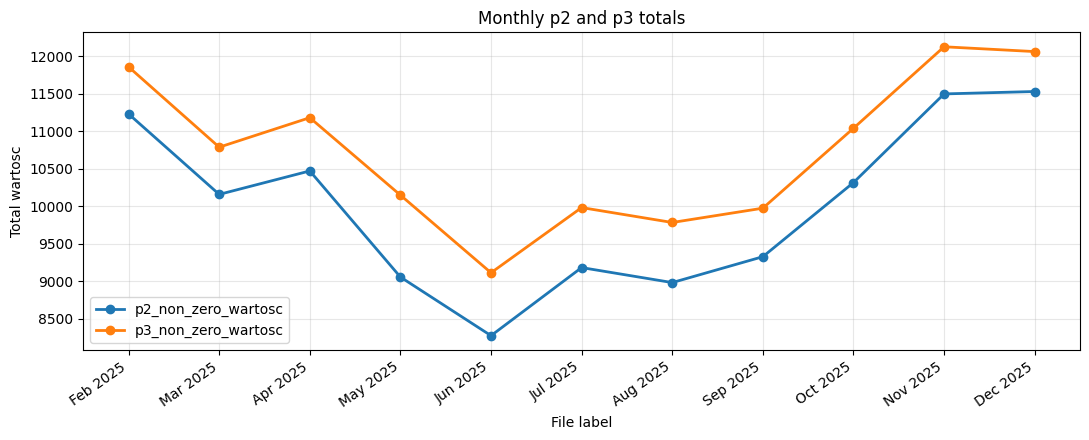

In [ ]:
# Final monthly p2/p3 chart from generated files
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# Add new generated files here in order
generated_files = [
    # (label, file_name)
    ("Feb 2025", "PSE_gen-jw_20260212_191444.csv"),
    ("Mar 2025", "PSE_gen-jw_20260212_193540.csv"),
    ("Apr 2025", "PSE_gen-jw_20260212_194112.csv"),
    ("May 2025", "PSE_gen-jw_20260212_194619.csv"),
    ("Jun 2025", "PSE_gen-jw_20260212_195130.csv"),
    ("Jul 2025", "PSE_gen-jw_20260212_195823.csv"),
    ("Aug 2025", "PSE_gen-jw_20260212_200747.csv"),
    ("Sep 2025", "PSE_gen-jw_20260212_201342.csv"),
    ("Oct 2025", "PSE_gen-jw_20260212_202203.csv"),
    ("Nov 2025", "PSE_gen-jw_20260212_202815.csv"),
    ("Dec 2025", "PSE_gen-jw_20260212_204546.csv"),
]

base_dir = Path("/Users/pkiszk/Coding/pyPSA-PL/PyPSA_workspace")
rows = []

for label, file_name in generated_files:
    csv_path = base_dir / file_name
    if not csv_path.exists():
        print(f"Skipping missing file: {csv_path}")
        continue

    df_month = load_pse_gen_jw_csv(csv_path)
    stats_month = all_codes_stats_jupyter(df_month)
    totals = stats_month[[
        "p1_non_zero_wartosc",
        "p2_non_zero_wartosc",
        "p3_non_zero_wartosc",
        "p5_non_zero_wartosc",
    ]].sum(skipna=True)

    rows.append({
        "label": label,
        "file_name": file_name,
        "p1_non_zero_wartosc": float(totals["p1_non_zero_wartosc"]),
        "p2_non_zero_wartosc": float(totals["p2_non_zero_wartosc"]),
        "p3_non_zero_wartosc": float(totals["p3_non_zero_wartosc"]),
        "p5_non_zero_wartosc": float(totals["p5_non_zero_wartosc"]),
    })

monthly_totals = pd.DataFrame(rows)
display(monthly_totals)

if not monthly_totals.empty:
    fig, ax = plt.subplots(figsize=(11, 4.5))
    ax.plot(monthly_totals["label"], monthly_totals["p2_non_zero_wartosc"], marker="o", linewidth=2, label="p2_non_zero_wartosc")
    ax.plot(monthly_totals["label"], monthly_totals["p3_non_zero_wartosc"], marker="o", linewidth=2, label="p3_non_zero_wartosc")

    ax.plot(monthly_totals["label"], monthly_totals["p5_non_zero_wartosc"], marker="o", linewidth=2, label="p5_non_zero_wartosc")
    ax.set_title("Monthly p2 and p3 totals, p5")
    ax.set_xlabel("File label")
    ax.set_ylabel("Total wartosc")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.xticks(rotation=35, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No monthly totals to plot.")


,label,file_name,p1_non_zero_wartosc,p2_non_zero_wartosc,p3_non_zero_wartosc,p5_non_zero_wartosc
0,Feb 2025,PSE_gen-jw_20260212_191444.csv,10038.775684,11232.343584,11860.082314,12890.787465
1,Mar 2025,PSE_gen-jw_20260212_193540.csv,8624.865462,10159.472274,10789.125464,11494.176700
2,Apr 2025,PSE_gen-jw_20260212_194112.csv,8690.763445,10472.319792,11182.500770,12030.087695
3,May 2025,PSE_gen-jw_20260212_194619.csv,7116.885351,9057.234674,10149.586907,11068.765680
4,Jun 2025,PSE_gen-jw_20260212_195130.csv,6788.433396,8275.467002,9114.246363,9983.596405
5,Jul 2025,PSE_gen-jw_20260212_195823.csv,7559.176688,9183.447252,9983.593130,10908.545220
6,Aug 2025,PSE_gen-jw_20260212_200747.csv,7384.078298,8983.393976,9784.774109,10475.085545
7,Sep 2025,PSE_gen-jw_20260212_201342.csv,7823.658095,9328.582914,9975.597061,10854.300025
8,Oct 2025,PSE_gen-jw_20260212_202203.csv,8869.083744,10317.049202,11041.614145,11608.144305
9,Nov 2025,PSE_gen-jw_20260212_202815.csv,10072.890624,11499.402128,12128.125145,12776.725765


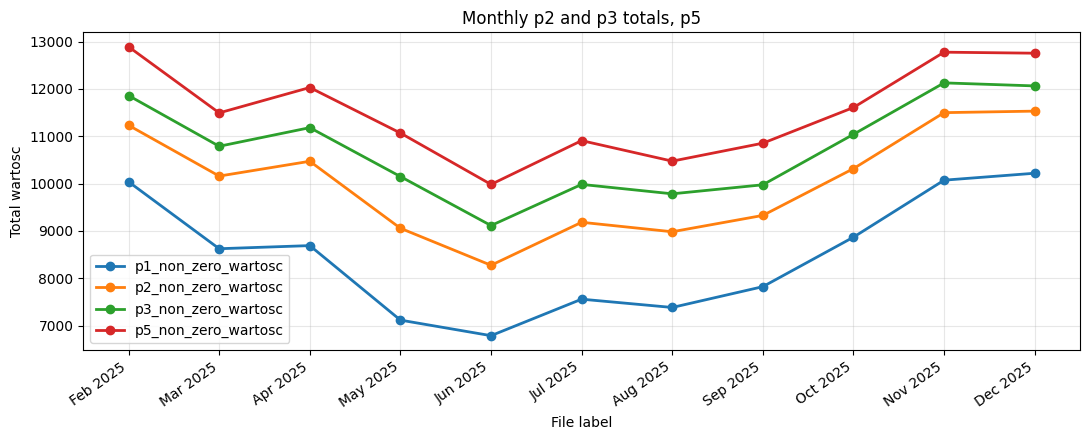

In [ ]:

monthly_totals = pd.DataFrame(rows)
display(monthly_totals)

if not monthly_totals.empty:
    fig, ax = plt.subplots(figsize=(11, 4.5))
    ax.plot(monthly_totals["label"], monthly_totals["p1_non_zero_wartosc"], marker="o", linewidth=2, label="p1_non_zero_wartosc")
    
    ax.plot(monthly_totals["label"], monthly_totals["p2_non_zero_wartosc"], marker="o", linewidth=2, label="p2_non_zero_wartosc")
    ax.plot(monthly_totals["label"], monthly_totals["p3_non_zero_wartosc"], marker="o", linewidth=2, label="p3_non_zero_wartosc")

    ax.plot(monthly_totals["label"], monthly_totals["p5_non_zero_wartosc"], marker="o", linewidth=2, label="p5_non_zero_wartosc")
    ax.set_title("Monthly p2 and p3 totals, p5")
    ax.set_xlabel("File label")
    ax.set_ylabel("Total wartosc")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.xticks(rotation=35, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No monthly totals to plot.")